### Imports

In [1]:
### Import modules
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.api import MarkovAutoregression
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm import tqdm
from numba import njit
import os
import re

plt.rcParams.update({'font.size': 17}) # Increase font size of plt plots
np.random.seed(10) # Set seed for reproducibility

In [2]:
# Calculate mean squared error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Calculate RMSE ratio
def rmse_ratio(YT, forecasts1, forecasts2):
    rmse1 = np.sqrt(mse(YT, forecasts1))
    rmse2 = np.sqrt(mse(YT, forecasts2))
    return rmse1/rmse2

### Generating Sample

In [3]:
### Generate the sample

# Define the STAR model
def star_model(yt_minus, a, c2, a2, phi2, c, sigma, phi, theta):
    yt = (1 - norm.cdf(a * (np.mean(yt_minus[-10:]) - a2))) * (c + phi*yt_minus[-1]) + norm.cdf(a * (np.mean(yt_minus[-10:]) - a2)) * (c2 + phi2*yt_minus[-1]) + sigma * np.random.normal() + theta * sigma * np.random.normal()
    return yt

def generate_sample(n):
    # Define the parameters of the STAR model
    a = 40
    a2 = -0.043
    c = -0.002
    phi = 0.95
    c2 = 0
    phi2 = 0
    sigma = 0.1
    theta = -0.3
    # Generate yt using the STAR model
    YT = np.zeros(n)
    for i in range(1, n):
        YT[i] = star_model(YT[:i], a, c2, a2, phi2, c, sigma, phi, theta)
    return YT

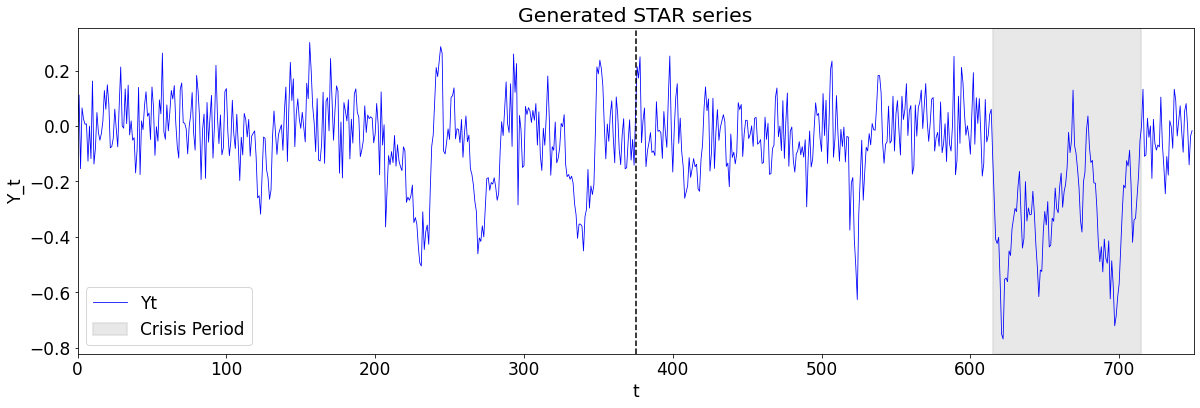

In [4]:
num_points = 750
YT = generate_sample(num_points)
test_begin = num_points // 2

# Plot the generated series
plt.figure(figsize=(20,6))
plt.plot(YT, linewidth=0.8, color='blue', label='Yt')
plt.title('Generated STAR series')
plt.xlabel('t')
plt.ylabel('Y_t')
plt.axvline(x=test_begin, color='black', linestyle='--')
plt.axvspan(615, 715, color='lightgrey', alpha=0.5, lw=2, label='Crisis Period')
plt.xlim(0, num_points)
plt.legend()
plt.show()

In [5]:
YT_train  = YT[:num_points//2]
YT_test = YT[num_points//2:]

### ARMA Model

In [6]:
### Fit the ARMA model
import warnings
warnings.filterwarnings("ignore")

# Define a function to find the best parameters p in {0,1,...,12} and q in {0,1,2} for the ARMA model
def find_best_arma(YT):
    bic_smallest = float('inf')
    for p in range(0, 11):
        for q in range(0, 3):
            arma_model = sm.tsa.arima.ARIMA(YT, order=(p,0,q))
            # arma_model.initialize_approximate_diffuse() # Without this you will get a LU decomp error, but with it the resuls do not match up
            # arma_model.initialize_stationary()
            arma_fitted = arma_model.fit()
            bic_current = arma_fitted.bic
            if bic_current < bic_smallest:
                bic_smallest = bic_current
                best_model = arma_fitted
    return best_model


In [ ]:
# Fit ARMA model to the whole data (replication)
steps = 1
arma_fitted = find_best_arma(YT_train)
print("YT_train: ARMA(", arma_fitted.model_orders['ar'], ",", arma_fitted.model_orders['ma'], ")")

predictions_ARMA = np.concatenate([arma_fitted.predict(), arma_fitted.forecast(steps=1), np.zeros(len(YT_test)-1)])

for t in tqdm(range(test_begin+1, len(YT))):
    if t == test_begin+1 or t % steps == 0:
        arma_fitted = find_best_arma(YT[:t])
        p, q = (arma_fitted.model_orders['ar'], arma_fitted.model_orders['ma'])
        print(t-1)
        print("ARMA(", arma_fitted.model_orders['ar'], ",", arma_fitted.model_orders['ma'], ")")
    else: 
        arma_fitted = sm.tsa.arima.ARIMA(YT[:t], order=(p,0,q)).fit()
  
    predictions_ARMA[t] = arma_fitted.forecast(steps=1)[0]

In [9]:
# Load the results from the csv file
predictions_df = pd.read_csv('SIM_predictions.csv')

YT = np.array(predictions_df['True values'])
test_begin = num_points//2

predictions_ARMA = predictions_df['ARMA'] 

overall MSE ARMA 1-step ahead: 0.012268107192865547
in-sample MSE: 0.011991968738417052
out of sample MSE ARMA 1-step ahead: 0.012544245647314042


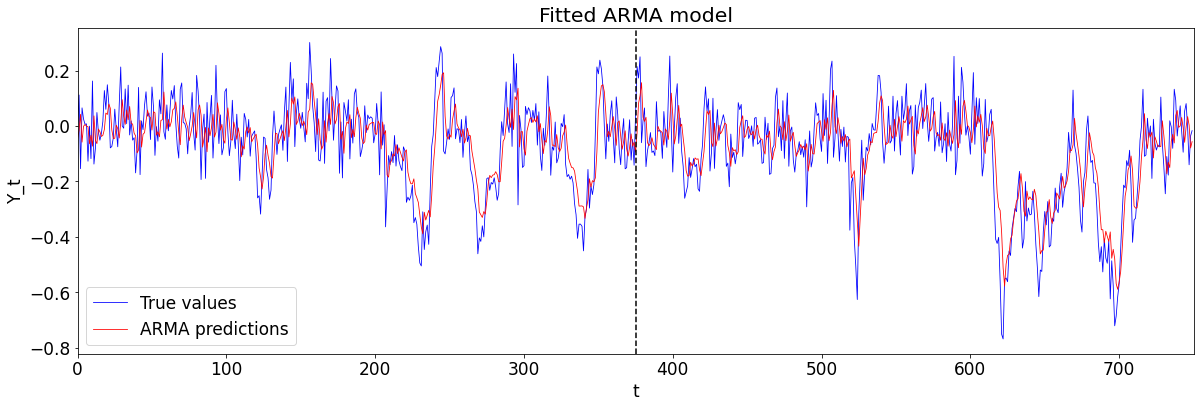

In [12]:
print('overall MSE ARMA 1-step ahead:', mse(YT, predictions_ARMA))
print('in-sample MSE:', mse(YT[:test_begin], predictions_ARMA[:test_begin]))
print('out of sample MSE ARMA 1-step ahead:', mse(YT[test_begin:], predictions_ARMA[test_begin:]))

plt.figure(figsize=(20,6))
plt.plot(YT, linewidth=0.8, color='blue', label='True values')
plt.plot(predictions_ARMA, linewidth=0.8, color='red', label='ARMA predictions')
plt.title('Fitted ARMA model')
plt.xlabel('t')
plt.ylabel('Y_t')
plt.xlim(0, num_points)
plt.axvline(x=test_begin, color='black', linestyle='--')
plt.legend()
plt.show()



### Match to level

In [7]:
### Match-to-level
# Define the distance function
@njit
def dist(Y1, Y2):
    # if len(Y1) != len(Y2): # Check 
    #     return TypeError
    k = len(Y1)
    sum = 0
    for i in range(0, k):
        Wi = 1/(k-i)
        sum += Wi * (Y1[i] - Y2[i])**2
    return sum


# Define the function to find the m best matching blocks of length k
@njit
def find_similar_periods(YT, t, m, k):
    '''
    Input:
        YT: univariate series of data
        t: current index
        k: length of interval to be matched
        m: number of matching blocks to be returned
    Output:
        the m best matching blocks of length k, return tuple:(distance, block, end-index of block)
    '''
    num_blocks = t - k + 1
    distances = np.empty((num_blocks, 3), dtype=np.float64)
    XT = YT[t-k+1:t+1]

    for i in range(num_blocks):
        current_block = YT[i:i+k]
        distance = dist(XT, current_block)
        distances[i, 0] = distance
        distances[i, 1] = i
        distances[i, 2] = i + k

    # Sort based on distance
    sorted_indices = np.argsort(distances[:, 0])
    sorted_distances = distances[sorted_indices]

    # Retrieve the top m blocks
    top_m_blocks = sorted_distances[:m]

    # Extract blocks with their corresponding distance and end index
    result = [(top_m_blocks[i, 0], YT[int(top_m_blocks[i, 1]):int(top_m_blocks[i, 1])+k], int(top_m_blocks[i, 2])) for i in range(m)]
    
    return result

Min index on: 622
t: 632
XT: [-0.37040696 -0.33471021 -0.29770521 -0.30949012 -0.21925063]
(0.005127810184233426, array([-0.41678633, -0.36047836, -0.40056468, -0.29136294, -0.19025728]), 276)
(0.00526465605836231, array([-0.27565242, -0.25697948, -0.26826092, -0.25229841, -0.21341791]), 226)
(0.00735401123903162, array([-0.32738481, -0.30074895, -0.15694285, -0.29657912, -0.2165191 ]), 346)
(0.007601862191109081, array([-0.36217244, -0.45088612, -0.32738481, -0.30074895, -0.15694285]), 344)
(0.009286121055290001, array([-0.36047836, -0.40056468, -0.29136294, -0.19025728, -0.18668438]), 277)


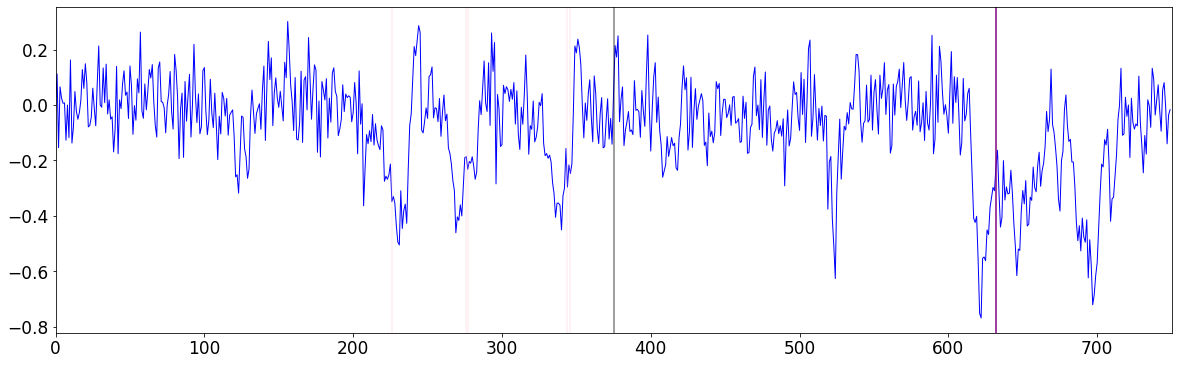

In [8]:
# Find argmin(YT)
min_index = min(range(len(YT)), key=YT.__getitem__)
print('Min index on:', min_index)

# Define parameters
t = min_index+10
print("t:", t)
m=5
k=5
print("XT:", YT[t-k+1:t+1])

best_fits = find_similar_periods(YT, t, m, k)


# Plot the results
plt.figure(figsize=(20,6))
plt.plot(YT, color='blue', linewidth=1)
plt.xlim(0, len(YT))
plt.axvline(x = len(YT)//2, color = 'black', alpha=0.5)
plt.axvline(x = t, color = 'purple') # Plot the a vertical line on t
for fit in best_fits:
    print(fit)
    plt.axvline(x = fit[2], color = 'pink', linewidth=0.4) # Plot a pink line on final index of the matching block
plt.show()

### Forecast Adjustment

In [ ]:
### Forecast Adjustment
# Define function to predict single values
def predict(YT, t, best_fits, ARMA_predictions, h):
    '''
    Input:
        YT: ndarray, univariate series of data
        t: int, current index
        best_fits: (m x 3) ndarray, the m best matching blocks. for each m: (distances, block, end-index)
        amra_predictions: ndarray, predictions from ARMA model
    Output:
        forecast: float, the adjusted forecast for index t
    '''
    m = len(best_fits)
    sum = 0
    for fit in best_fits:
        matching_index = fit[2]
        sum += YT[matching_index+h] - ARMA_predictions[matching_index+h]
    return sum/m + ARMA_predictions[t+h]


# Find the best parameters
def optimal_m_k(YT, ARMA_predictions, t1, T):
    mse_dict = {} # Dictionary that maps (m,k) to corresponding MSE

    # Test different parameters
    for m in range(2,80, 2):
        for k in range(2, 80, 2):
            sum_squared = 0
            count = 0
            for t in range(t1, T-1):
                best_fits = find_similar_periods(YT, t, m, k)
                forecast = predict(YT, t, best_fits, ARMA_predictions, 1)
                sum_squared += (YT[t+1] - forecast)**2
                count += 1
            
            mse_current = sum_squared / count
            mse_dict[(m, k)] = mse_current

    # Select best 1/4th of the parameters
    sorted_mse_dict = sorted(mse_dict.items(), key=lambda x: x[1])
    best_params = sorted_mse_dict[:len(sorted_mse_dict)//4]
    # Take the average of the best parameters
    m = int(np.mean([param[0][0] for param in best_params]))
    k = int(np.mean([param[0][1] for param in best_params]))
    return m, k

In [ ]:
# Fit NN model to the whole data
t1 = 190

m,k = optimal_m_k(YT, predictions_ARMA, t1, test_begin)
predictions_NN = np.concatenate([predictions_ARMA[:test_begin], np.zeros(len(YT_test))])
for t in range(t1, test_begin):
    best_fits = find_similar_periods(YT, t, m, k)
    predictions_NN[t] =  predict(YT, t, best_fits, predictions_ARMA)
     
for t in tqdm(range(test_begin, len(YT))):
    m, k = optimal_m_k(YT, predictions_ARMA, t1, t)
    best_fits = find_similar_periods(YT, t-1, m, k)
    predictions_NN[t] = predict(YT, t-1, best_fits, predictions_ARMA, h=1)

In [ ]:
# Save results to csv file
predictions_df = pd.DataFrame()
predictions_df['True values'] = YT
predictions_df['ARMA'] = predictions_ARMA
predictions_df['NN'] = predictions_NN

# predictions_df.to_csv('SIM_predictions.csv', index=False)

In [4]:
# Load from CVS file
# Load the results from the csv file
predictions_df = pd.read_csv('SIM_predictions.csv')

YT = np.array(predictions_df['True values'])
test_begin = len(YT)//2

predictions_ARMA = predictions_df['ARMA'] 
predictions_NN = predictions_df['NN']
predictions_NN[:test_begin] = np.zeros(test_begin)

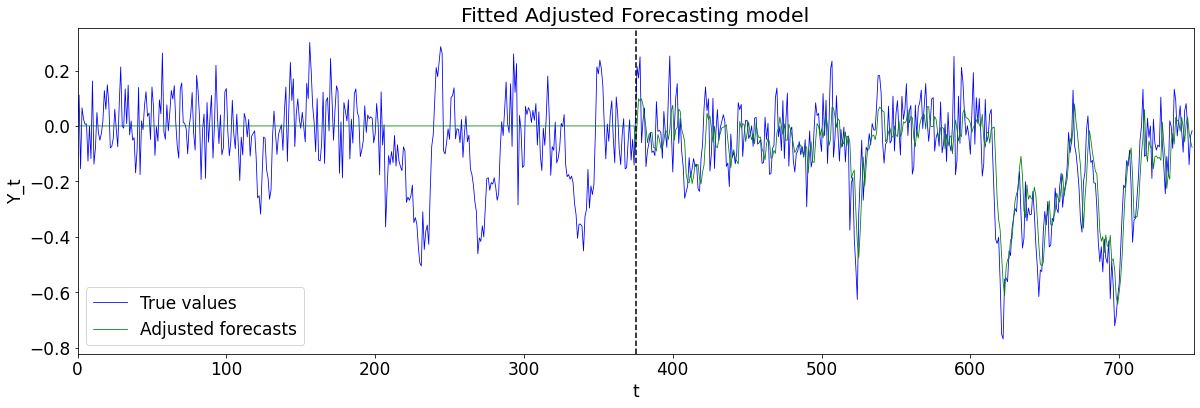

In [6]:
# Plot the adjusted forecasts results
plt.figure(figsize=(20,6))
plt.plot(YT, linewidth=0.8, color='blue', label='True values')
plt.plot(predictions_NN, linewidth=0.8, color='green', label='Adjusted forecasts')
plt.title('Fitted Adjusted Forecasting model')
plt.xlabel('t')
plt.ylabel('Y_t')
plt.xlim(0, len(YT))
plt.axvline(x = test_begin, color = 'black', linestyle='--')
# plt.axvspan(615, 715, color='lightgrey', alpha=0.5, lw=2, label='Crisis Period')
plt.legend()
plt.show()


# Plot forecasting errors of the adjusted forecasts and the ARMA forecasts
# errors_NN = YT_test - predictions_NN[test_begin:]
# errors_ARMA = YT_test - predictions_ARMA[test_begin:]
# plt.figure(figsize=(20,6))
# plt.plot(range(test_begin, len(YT)), errors_NN, color='green', label='Adjusted forecast errors')
# plt.plot(range(test_begin, len(YT)), errors_ARMA, color='red', label='ARMA forecast errors')
# plt.xlim(len(YT_test), len(YT))
# plt.title('Forecasting errors')
# plt.legend()
# plt.show()

In [21]:
### Plot recursive cumulative sum of squares difference
# Define function to calculate the cumulative sum of squares difference
def cumsum_sos_diff(true_values, pred1, pred2):
    sos_diff = np.cumsum((pred1-true_values)**2 - (pred2-true_values)**2)
    return sos_diff

# Define function to plot the cumulative sum of squares difference
def plot_cumulative_sum_squares_diff(true_values, pred1, pred2):
    # Calculate the sum of squares difference
    sos_diff = cumsum_sos_diff(true_values, pred1, pred2)
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(range(test_begin, len(YT)), sos_diff, color='blue', marker='+', linewidths=0.7)
    plt.axhline(0, color = 'black', alpha=0.5)
    plt.xlim(test_begin, len(YT))
    plt.show()

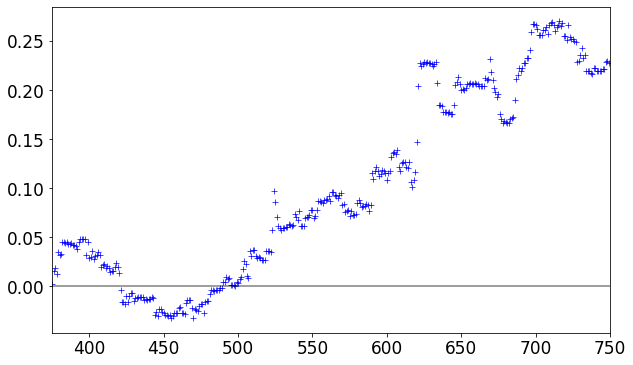

In [22]:
plot_cumulative_sum_squares_diff(YT[test_begin:], predictions_ARMA[test_begin:], predictions_NN[test_begin:])

### Everything in one method

#### Functions

In [37]:
### Functions
# Calculate out-of-sample mean squared error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Define the STAR model
def star_model(yt_minus, a, c2, a2, phi2, c, sigma, phi, theta):
    yt = (1 - norm.cdf(a * (np.mean(yt_minus[-10:]) - a2))) * (c + phi*yt_minus[-1]) + norm.cdf(a * (np.mean(yt_minus[-10:]) - a2)) * (c2 + phi2*yt_minus[-1]) + sigma * np.random.normal() + theta * sigma * np.random.normal()
    return yt

def generate_sample(n):
    # Define the parameters of the STAR model
    a = 40
    a2 = -0.043
    c = -0.002
    phi = 0.95
    c2 = 0
    phi2 = 0
    sigma = 0.1
    theta = -0.3
    # Generate yt using the STAR model
    YT = np.zeros(n)
    for i in range(1, n):
        YT[i] = star_model(YT[:i], a, c2, a2, phi2, c, sigma, phi, theta)
    return YT

import warnings
warnings.filterwarnings("ignore")
# Define a function to find the best parameters p in {0,1,...,10} and q in {0,1,2} for the ARMA model
def find_best_arma(YT):
    bic_smallest = float('inf')
    for p in range(0, 11):
        for q in range(0, 3):
            arma_model = sm.tsa.arima.ARIMA(YT, order=(p,0,q))
            arma_fitted = arma_model.fit()
            bic_current = arma_fitted.bic
            if bic_current < bic_smallest:
                bic_smallest = bic_current
                best_model = arma_fitted
    return best_model

### Match-to-level
# Define the distance function
@njit # Speeeeeed
def dist(Y1, Y2):
    # if len(Y1) != len(Y2): # Check 
    #     return TypeError
    k = len(Y1)
    sum = 0
    for i in range(0, k):
        Wi = 1/(k-i)
        sum += Wi * (Y1[i] - Y2[i])**2
    return sum

@njit # Speeeed
# Define the function to find the m best matching blocks of length k
def find_similar_periods(YT, t, m, k):
    '''
    Input:
        YT: univariate series of data
        t: current index
        k: length of interval to be matched
        m: number of matching blocks to be returned
    Output:
        the m best matching blocks of length k, return tuple:(distance, block, end-index of block)
    '''
    num_blocks = t - k + 1
    distances = np.empty((num_blocks, 3), dtype=np.float64)
    XT = YT[t-k+1:t+1]

    for i in range(num_blocks):
        current_block = YT[i:i+k]
        distance = dist(XT, current_block)
        distances[i, 0] = distance
        distances[i, 1] = i
        distances[i, 2] = i + k

    # Sort based on distance
    sorted_indices = np.argsort(distances[:, 0])
    sorted_distances = distances[sorted_indices]
    # Retrieve the top m blocks
    top_m_blocks = sorted_distances[:m]
    # Extract blocks with their corresponding distance and end index
    result = [(top_m_blocks[i, 0], YT[int(top_m_blocks[i, 1]):int(top_m_blocks[i, 1])+k], int(top_m_blocks[i, 2])) for i in range(m)]
    
    return result

### Forecast Adjustment
# Define function to predict single values
def predict(YT, t, best_fits, ARMA_predictions, h=0):
    '''
    Input:
        YT: ndarray, univariate series of data
        t: int, current index
        best_fits: (m x 3) ndarray, the m best matching blocks. for each m: (distances, block, end-index)
        arma_predictions: ndarray, predictions from ARMA model
        h: int, the number of steps ahead to forecast (if h>0)
    Output:
        forecast: float, the adjusted forecast for index t
    '''
    m = len(best_fits)
    sum = 0
    for fit in best_fits:
        matching_index = fit[2]
        sum += YT[matching_index+h] - ARMA_predictions[matching_index+h]
    return sum/m + ARMA_predictions[t+h]


# Find the best parameters
def optimal_m_k(YT, ARMA_predictions, t1, T):
    mse_dict = {} # Dictionary that maps (m,k) to corresponding MSE

    # Test different parameters
    for m in range(2,80, 6):
        for k in range(2, 80, 6):
            sum_squared = 0
            count = 0
            for t in range(t1, T-1):
                best_fits = find_similar_periods(YT, t, m, k)
                forecast = predict(YT, t, best_fits, ARMA_predictions, 1)
                sum_squared += (YT[t+1] - forecast)**2
                count += 1
            
            mse_current = sum_squared / count
            mse_dict[(m, k)] = mse_current

    # Select best 1/4th of the parameters
    sorted_mse_dict = sorted(mse_dict.items(), key=lambda x: x[1])
    best_params = sorted_mse_dict[:len(sorted_mse_dict)//4]
    # Take the average of the best parameters
    m = int(np.mean([param[0][0] for param in best_params]))
    k = int(np.mean([param[0][1] for param in best_params]))
    return m, k

def rmse_ratio(YT, forecasts1, forecasts2):
    rmse1 = np.sqrt(mse(YT, forecasts1))
    rmse2 = np.sqrt(mse(YT, forecasts2))
    return rmse1/rmse2


#### Code

In [ ]:
col = 'SIM'
print(f'Now computing for {col}')

YT = generate_sample(750) 

t1 = 190
test_begin = len(YT) // 2
test_end = len(YT)-1


# Fit ARMA model to the whole data
arma_fitted = find_best_arma(YT[:test_begin])
predictions_ARMA = np.concatenate([arma_fitted.predict(), arma_fitted.forecast(steps=1), np.zeros(len(YT)-test_begin-1)])
for t in tqdm(range(test_begin+1, len(YT))):
    arma_fitted = find_best_arma(YT[:t])
    predictions_ARMA[t] = arma_fitted.forecast(steps=1)[0]

print(f"\tFinished fitting ARMA model for {col}")

# Fit NN model to the whole data
m, k = optimal_m_k(YT, predictions_ARMA, t1, test_begin)
predictions_NN = np.zeros(len(YT))
for t in range(t1, test_begin+1): # t1 - end of in-sample period
    best_fits = find_similar_periods(YT, t, m, k)
    predictions_NN[t] =  predict(YT, t, best_fits, predictions_ARMA)
for t in tqdm(range(test_begin+1, len(YT))): # out-of-sample period
    m, k = optimal_m_k(YT, predictions_ARMA, t1, t)
    best_fits = find_similar_periods(YT, t-1, m, k)
    predictions_NN[t] = predict(YT, t-1, best_fits, predictions_ARMA, h=1)

print(f"\tFinished fitting NN model for {col}")

# Plot the results
plt.figure(figsize=(20,6))
plt.plot(YT, linewidth=0.8, color='blue', label='True values')
plt.plot(predictions_ARMA, linewidth=0.8, color='red', label='ARMA predictions')
plt.plot(predictions_NN, linewidth=0.8, color='green', label='NN predictions')
plt.title(f'ARMA and NN forecasts for {col}')
plt.xlim(0, len(YT))
plt.axvline(x=test_begin, color='black', linestyle='--')
plt.legend()
plt.show()

# Compute MSE ratios

# Table 1: YT_test
ratio = rmse_ratio(YT[test_begin:test_end], predictions_NN[test_begin:test_end], predictions_ARMA[test_begin:test_end])
print('\tTable 1 RMSE ratio:', ratio)

plot_cumulative_sum_squares_diff(YT[test_begin:], predictions_ARMA[test_begin:], predictions_NN[test_begin:])

# Save results to csv file
predictions_df = pd.DataFrame()
predictions_df['True values'] = YT
predictions_df['ARMA'] = predictions_ARMA
predictions_df['NN'] = predictions_NN

if f"{col}_predictions.csv"  in os.listdir():
    predictions_df_old = pd.read_csv(f'{col}_predictions.csv')
    predictions_df['ARMA'] = predictions_df_old['ARMA']
    predictions_df['NN'] = predictions_df_old['NN']

predictions_df.to_csv(f'{col}_predictions.csv', index=False)

### Competing models

These are not the competing models that made it into the paper

#### Markov-switching autoregression model

In [ ]:
def fit_MS_AR(YT, p=1):
    model = MarkovAutoregression(YT, k_regimes=2, order=p, trend='n', switching_ar=False, switching_trend=True)
    MS_AR_fitted = model.fit()
    return MS_AR_fitted.predict()

In [ ]:
MS_AR_predictions = fit_MS_AR(YT, best_p_q[0])

# PLot the fitted model
plt.figure(figsize=(20,6))
plt.plot(YT, color='blue', linewidth=1)
plt.plot(MS_AR_predictions, color='red', linewidth=1)
plt.xlim(0, len(YT))
plt.show()

# Print MSE
print("MSE whole sample:", mse(YT[1:], MS_AR_predictions))

In [ ]:
MS_AR_model = MarkovAutoregression(YT, k_regimes=2, order=5, trend='n', switching_ar=False, switching_trend=True)
MS_AR_model = MS_AR_model.fit()
MS_AR_model.summary()

#### SETAR

In [ ]:
def transition_function(y_prev, gamma1, gamma2):
    return 1 / (1 + np.exp(-gamma1 * (y_prev - gamma2)))

def fit_SETAR(params, y, lag):
    gamma1, gamma2, c1, c2, phi1, phi2, sigma2 = params
    c = np.zeros_like(y)
    phi = np.zeros_like(y)
    for t in range(len(y)):
        c[t] = transition_function(y[max(0, t-lag)], gamma1, gamma2) * c1 + \
               (1 - transition_function(y[max(0, t-lag)], gamma1, gamma2)) * c2
        phi[t] = transition_function(y[max(0, t-lag)], gamma1, gamma2) * phi1 + \
                 (1 - transition_function(y[max(0, t-lag)], gamma1, gamma2)) * phi2
    y_pred = np.zeros_like(y)
    for t in range(lag, len(y)):
        y_pred[t] = c[t] + np.sum([phi[t-l] * y[t-l] for l in range(1, lag+1)]) + np.random.normal() * np.sqrt(abs(sigma2))
    return y_pred

def objective_function(params, y, lag):
    y_pred = fit_SETAR(params, y, lag)
    residuals = y[lag:] - y_pred[lag:]
    return np.sum(residuals ** 2)

def likelihood(params, y, lag):
    gamma1, gamma2, c1, c2, phi1, phi2, sigma2 = params
    y_pred = fit_SETAR(params, y, lag)
    residuals = y[lag:] - y_pred[lag:]
    log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * sigma2) + (residuals ** 2) / sigma2)
    return -log_likelihood

def estimate_SETAR_params(YT, lag):
    # Step 1: Initial Parameter Guesses
    gamma1_guess = 4 # 1    
    gamma2_guess = -0.1 # 0
    c1_guess = 0.004 # np.mean(YT)
    c2_guess =  -0.04 # np.mean(YT)
    phi1_guess = 0.014 # 0.5
    phi2_guess = 0.8 # 0.5
    sigma2_guess = 0.013 # np.var(YT)
    lag = 1
     
    # Step 2: Nonlinear Least Squares (NLS) Estimation
    initial_params = [gamma1_guess, gamma2_guess, c1_guess, c2_guess, phi1_guess, phi2_guess, sigma2_guess]
    result = minimize(objective_function, initial_params, args=(YT, lag), method='Nelder-Mead')
    params_NLS = result.x

    # Step 4: Refinement with Maximum Likelihood Estimation (MLE)
    result_mle = minimize(likelihood, params_NLS, args=(YT, lag), method='Nelder-Mead')
    return result_mle.x 

# perform out-of-sample forecasting with horizon h
def forecast_SETAR(YT, t, h, params, lag):
    gamma1, gamma2, c1, c2, phi1, phi2, sigma2 = params
    yt = YT[t]  # Current value of the time series
    for i in range(h):
        # Calculate regime-specific parameters
        c = transition_function(yt, gamma1, gamma2) * c1 + \
            (1 - transition_function(yt, gamma1, gamma2)) * c2
        phi = transition_function(yt, gamma1, gamma2) * phi1 + \
              (1 - transition_function(yt, gamma1, gamma2)) * phi2
        # Forecast next value using the SETAR model
        yt = c + sum([phi * YT[t-l] for l in range(1, lag+1)]) + np.random.normal() * np.sqrt(abs(sigma2))
    return yt
    

In [ ]:
# Fit the SETAR model on in-sample data
lag = 1
params_MLE = estimate_SETAR_params(YT_train, lag)
SETAR_predictions = list(fit_SETAR(params_MLE, YT_train, lag))

# Perform out-of-sample prediction
forecasts_SETAR = []
h = 1
for t in range(test_begin-1, len(YT)-1):
    forecast = forecast_SETAR(YT, t, h, params_MLE, lag)
    forecasts_SETAR.append(forecast)

# PLot the results
plt.figure(figsize=(20,6))
plt.plot(YT, color='blue', linewidth=1)
plt.plot(np.concatenate([SETAR_predictions, forecasts_SETAR]), color='red')
plt.xlim(0, len(YT))
plt.axvline(x = test_begin, color = 'black', alpha=0.5)
plt.show()

# Print MSE
print("MSE in-sample:", mse(YT_train, SETAR_predictions))
print("MSE out-of-sample:", mse(YT_test, forecasts_SETAR))

In [ ]:
### Calculate out-of-sample MSE for different horizons
for h in [1, 3, 6, 12]:
    length = 50
    forecasts = []
    for t in range(375, 375 + length):
        forecasts.append(forecast_SETAR(YT, t, h, params_MLE, lag))
    plt.figure(figsize=(20,6))
    plt.plot(range(375+h, 375+h+length), YT[375+h:375+h+length], color='blue')
    plt.plot(range(375+h, 375+h+length), forecasts, color='red')
    plt.title('Out-of-sample forecasting with horizon h=' + str(h))
    plt.xlim(375+h, 375+h+length)
    plt.show()

    print("MSE: ", mse(YT[375+h:375+h+length], forecasts))


#### Exponential Smoothing

In [ ]:
### Exponential Smoothing
def fit_ES(YT, gamma):
    ES_predictions = np.zeros(len(YT))
    ES_predictions[0] = YT[0]
    for i in range(1, len(YT)):
        ES_predictions[i] = gamma * YT[i-1] + (1-gamma) * ES_predictions[i-1]
    return ES_predictions

def optimal_parameter_ES(YT_train):
    lowest_rmse = float('inf')
    for gamma in [0.1, 0.3, 0.5, 0.7, 0.9]:
        ES_predictions = fit_ES(YT_train, gamma)
        rmse_current = np.sqrt(np.mean((YT_train - ES_predictions)**2))
        if rmse_current < lowest_rmse:
            lowest_rmse = rmse_current
            best_gamma = gamma
    return best_gamma

def forecast_ES(YT, t, gamma):
    return (1-gamma) / (1-gamma**t) * sum([gamma**(t-i) * YT[i] for i in range(t)])

In [ ]:
# Find optimal gamma and fit model
best_gamma = optimal_parameter_ES(YT_train)
print("Best gamma:", best_gamma)
ES_predictions = fit_ES(YT_train, best_gamma)

h = 1
forecasts_ES = []
for t in range(test_begin-h, len(YT)-h):
    forecast = forecast_ES(YT, t, best_gamma)
    forecasts_ES.append(forecast)

# Plot the results
plt.figure(figsize=(20,6))
plt.plot(YT, color='blue', linewidth=1)
plt.plot(np.concatenate([ES_predictions, forecasts_ES]), color='red', linewidth=1)
plt.axvline(x = test_begin, color = 'black', alpha=0.5)
plt.xlim(0, len(YT))
plt.show()

# Print MSE
print("MSE in-sample:", mse(YT_train, ES_predictions))
print("MSE out-of-sample:", mse(YT_test, forecasts_ES)) # Should be the same

In [ ]:
### Fit_ES on whole sample
best_gamma = optimal_parameter_ES(YT_train)
print("Best gamma:", best_gamma)
ES_predictions = fit_ES(YT, best_gamma)

# Plot the results
plt.figure(figsize=(20,6))
plt.plot(YT, color='blue', linewidth=1)
plt.plot(ES_predictions, color='red', linewidth=1)
plt.xlim(0, len(YT))
plt.show()

# Print MSE
print("MSE whole sample:", mse(YT, ES_predictions))
print("MSE in sample:", mse(YT_train, ES_predictions[:test_begin]))
print("MSE out-of-sample:", mse(YT_test, ES_predictions[test_begin:]))


ES_predictions = [YT[0]]
for t in range(1, len(YT)):
    ES_predictions.append(forecast_ES(YT, t, best_gamma))

# Plot the results
plt.figure(figsize=(20,6))
plt.plot(YT, color='blue', linewidth=1)
plt.plot(ES_predictions, color='red', linewidth=1)
plt.xlim(0, len(YT))
plt.show()

# Print MSE
print("MSE whole sample:", mse(YT, ES_predictions))
print("MSE in sample:", mse(YT_train, ES_predictions[:test_begin]))
print("MSE out-of-sample:", mse(YT_test, ES_predictions[test_begin:]))

In [ ]:
### Calculate out-of-sample MSE for different horizons
for h in [1, 3, 6, 12]:
    length = 50
    forecasts = []
    for t in range(375, 375 + length):
        forecasts.append(forecast_ES(YT, t, best_gamma))
    plt.figure(figsize=(20,6))
    plt.plot(range(375+h, 375+h+length), YT[375+h:375+h+length], color='blue')
    plt.plot(range(375+h, 375+h+length), forecasts, color='red')
    plt.title('Out-of-sample forecasting with horizon h=' + str(h))
    plt.xlim(375+h, 375+h+length)
    plt.show()

    print("MSE: ", mse(YT[375+h:375+h+length], forecasts))

### Monte carlo

In [3]:
### Monte Carlo
np.random.seed()

if "monte_carlo_df.csv" in os.listdir():
    monte_carlo_df = pd.read_csv('monte_carlo_df.csv')
    last_m = int(re.findall(r'\d+', monte_carlo_df.columns[-1])[0]) # find the last iteration
else:
    monte_carlo_df = pd.DataFrame()
    last_m = 0

steps = 2

M_max = 100
M_range = range(last_m, M_max)

for M in M_range:
    try:
        print(f"Starting iteration {M}")
        # Generate sample
        n = 750
        YT = generate_sample(n)
        t1 = 190
        test_begin = n // 2

        # Fit the ARMA model to the out-of-sample data
        arma_fitted = find_best_arma(YT[:test_begin])
        predictions_ARMA = np.concatenate([arma_fitted.predict(), arma_fitted.forecast(steps=1), np.zeros(len(YT)-test_begin-1)])
        for t in tqdm(range(test_begin+1, len(YT))):
            if t == test_begin or t % steps == 0:
                arma_fitted = find_best_arma(YT[:t])
                p, q = (arma_fitted.model_orders['ar'], arma_fitted.model_orders['ma'])
            else:
                arma_fitted = sm.tsa.arima.ARIMA(YT[:t], order=(p,0,q)).fit() 
            predictions_ARMA[t] = arma_fitted.forecast(steps=1)[0]
        print(f"\tFinished fitting ARMA model for iteration {M}")

        # Fit NN model to the out-of-sample data
        predictions_NN = np.zeros(len(YT))
        for t in tqdm(range(test_begin, len(YT))):
            m, k = optimal_m_k(YT, predictions_ARMA, t1, t)
            best_fits = find_similar_periods(YT, t-1, m, k)
            predictions_NN[t] = predict(YT, t-1, best_fits, predictions_ARMA, h=1)
        print(f"\tFinished fitting NN model for iteration {M}")
        
        # Save the values
        monte_carlo_df[f'YT_{M}'] = YT
        monte_carlo_df[f'ARMA_{M}'] = predictions_ARMA
        monte_carlo_df[f'NN_{M}'] = predictions_NN

        # Save the RMSE_ratio
        RMSE_ratio = rmse_ratio(YT[test_begin:], predictions_NN[test_begin:], predictions_ARMA[test_begin:])
        print(f"\tRMSE ratio {M}: {RMSE_ratio}")
        
        # Save the results to csv
        monte_carlo_df.to_csv('monte_carlo_df.csv', index=False)
    except KeyboardInterrupt:
        print("KeyboardInterrupt")
        break
    except:
        print(f"Error in iteration {M}")
        if 'monte_carlo_error.csv' in os.listdir():
            monte_carlo_error = pd.read_csv('monte_carlo_error.csv')
        else:
            monte_carlo_error = pd.DataFrame()
        monte_carlo_error[f'error_{M}'] = YT
        monte_carlo_error.to_csv('monte_carlo_error.csv', index=False)

Starting iteration 91


100%|██████████| 374/374 [1:03:27<00:00, 10.18s/it]


	Finished fitting ARMA model for iteration 91


100%|██████████| 375/375 [25:58<00:00,  4.15s/it]


	Finished fitting NN model for iteration 91
	RMSE ratio 91: 0.9701309164543633
Starting iteration 92


100%|██████████| 374/374 [1:01:03<00:00,  9.80s/it]


	Finished fitting ARMA model for iteration 92


100%|██████████| 375/375 [25:39<00:00,  4.10s/it]


	Finished fitting NN model for iteration 92
	RMSE ratio 92: 0.9740222621052576
Starting iteration 93


100%|██████████| 374/374 [57:10<00:00,  9.17s/it] 


	Finished fitting ARMA model for iteration 93


100%|██████████| 375/375 [25:58<00:00,  4.16s/it]


	Finished fitting NN model for iteration 93
	RMSE ratio 93: 0.9601552504651577
Starting iteration 94


100%|██████████| 374/374 [1:00:18<00:00,  9.68s/it]


	Finished fitting ARMA model for iteration 94


100%|██████████| 375/375 [26:11<00:00,  4.19s/it]


	Finished fitting NN model for iteration 94
	RMSE ratio 94: 0.9570549247622488
Starting iteration 95


100%|██████████| 374/374 [51:43<00:00,  8.30s/it]


	Finished fitting ARMA model for iteration 95


100%|██████████| 375/375 [25:58<00:00,  4.16s/it]


	Finished fitting NN model for iteration 95
	RMSE ratio 95: 0.9511826939510014
Starting iteration 96


  7%|▋         | 28/374 [03:41<45:37,  7.91s/it] 


Error in iteration 96
Starting iteration 97


100%|██████████| 374/374 [59:55<00:00,  9.61s/it]


	Finished fitting ARMA model for iteration 97


100%|██████████| 375/375 [25:28<00:00,  4.08s/it]


	Finished fitting NN model for iteration 97
	RMSE ratio 97: 0.9698287362560083
Starting iteration 98


100%|██████████| 374/374 [59:17<00:00,  9.51s/it]


	Finished fitting ARMA model for iteration 98


100%|██████████| 375/375 [25:30<00:00,  4.08s/it]


	Finished fitting NN model for iteration 98
	RMSE ratio 98: 0.9924654329722026
Starting iteration 99


100%|██████████| 374/374 [1:01:20<00:00,  9.84s/it]


	Finished fitting ARMA model for iteration 99


100%|██████████| 375/375 [24:58<00:00,  4.00s/it]

	Finished fitting NN model for iteration 99
	RMSE ratio 99: 0.9478164564317535


Number of iterations: 89
Median RMSE ratio: 0.960947225762198


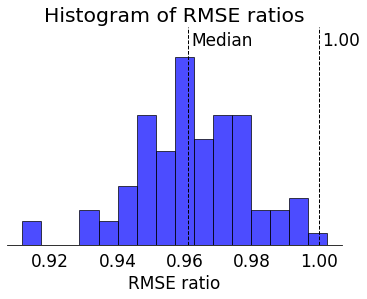

In [8]:
### Plot Monte Carlo results
monte_carlo_df = pd.read_csv('monte_carlo_df.csv')
RMSE_ratios = []
test_begin = 375

M_max = 100
for m in range(M_max):
    if f'YT_{m}' not in monte_carlo_df.columns:
        continue
    # print(f"Plotting results for iteration {m}")
    YT = monte_carlo_df[f'YT_{m}']
    predictions_ARMA = monte_carlo_df[f'ARMA_{m}']
    predictions_NN = monte_carlo_df[f'NN_{m}']

    # RMSE
    RMSE_ratio = rmse_ratio(YT[test_begin+1:], predictions_NN[test_begin+1:], predictions_ARMA[test_begin+1:])
    # print(f"\tRMSE ratio {m}: {RMSE_ratio}")
    RMSE_ratios.append(RMSE_ratio)
    # if RMSE_ratio > 1:
        # print(RMSE_ratio)
        # print(m)
        # # Plot the results
        # plt.figure(figsize=(20,6))
        # plt.plot(YT, color='blue', linewidth=1, label='True values')
        # plt.plot(predictions_ARMA, color='red', linewidth=1, label='ARMA')
        # plt.plot(predictions_NN, color='green', linewidth=1, label='NN')
        # plt.title(f'ARMA and NN forecasts for iteration {m}')
        # plt.xlim(0, len(YT))
        # plt.axvline(x=test_begin, color='black', linestyle='--')
        # plt.legend()
        # plt.show()

print(f"Number of iterations: {len(RMSE_ratios)}")
median = np.median(RMSE_ratios)
print(f"Median RMSE ratio: {median}")

plt.hist(RMSE_ratios, bins=16, edgecolor='k', color='blue', alpha=0.7)
plt.title('Histogram of RMSE ratios')
plt.xlabel('RMSE ratio')
plt.yticks([])
plt.tick_params(left = False, bottom = False)
plt.axvline(1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(median, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.ylim(min_ylim, max_ylim*1.1)
plt.text(median+0.001, max_ylim*1.01, 'Median')
plt.text(1+0.001, max_ylim*1.01, '1.00')
# plt.text(median+0.001, max_ylim*0.95, 'Median': {:.3f}'.format(median)') # With the median value
for spine in plt.gca().spines.values(): # make spines invisible
    if spine.spine_type != 'bottom':
        spine.set_visible(False)
plt.show()

# Save RMSE Ratios to csv
# pd.DataFrame(RMSE_ratios, columns=['RMSE_ratios']).to_csv('RMSE_ratios.csv', index=False)

In [7]:
### Construct CI for RMSE ratios
mean = np.mean(RMSE_ratios)
std = np.std(RMSE_ratios)
alpha = 0.05
n = len(RMSE_ratios)
z_value = norm.ppf(1-alpha/2)

lower_bound = mean - z_value * std / np.sqrt(n)
upper_bound = mean + z_value * std / np.sqrt(n)
print(f"95% CI for RMSE ratios: [{round(lower_bound, 3)}, {round(upper_bound, 3)}]")


95% CI for RMSE ratios: [0.959, 0.966]


In [15]:
### Test normality
# JB test
from scipy.stats import jarque_bera
jb_test = jarque_bera(RMSE_ratios)
print("Jarque-Bera p-value:", jb_test[1])
if jb_test[1] < 0.05:
    print("Reject normality")
else:
    print("Fail to reject normality")


Jarque-Bera p-value: 0.4163933889553496
Fail to reject normality
